In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

In [29]:
aval_prices = pd.read_parquet('../data/price_data/processed/aval_processed_data.parquet')
avax1_features = pd.read_parquet('../data/on_chain_data/processed/avax1_chain_processed.parquet')
avax2_features = pd.read_parquet('../data/on_chain_data/processed/avax2_chain_processed.parquet')

common_columns = avax1_features.columns
avax2_features = avax2_features[common_columns]
avax_features = pd.concat([avax1_features, avax2_features], ignore_index=True)

aval_prices['time_close'] = pd.to_datetime(aval_prices['time_close'])
aval_prices.set_index('time_close', inplace=True)
aval_prices.index = aval_prices.index.tz_localize('UTC')

common_length = min(len(aval_prices), len(avax_features))
aval_prices_aligned = aval_prices.iloc[:common_length].copy()
avax_features_aligned = avax_features.iloc[:common_length].copy()

In [30]:
avax_features_aligned.index = aval_prices_aligned.index

lag_cols = ['average_gas_limit', 'average_gas_used', 'average_size', 'average_total_difficulty']
avax_features_aligned[lag_cols] = avax_features_aligned[lag_cols].shift(1)

data = avax_features_aligned.join(aval_prices_aligned[['price_close']], how='inner')

data['price_diff'] = data['price_close'].diff()
threshold = data['price_diff'].std()

def get_signal(diff, threshold):
    if diff > threshold:
        return 'Buy'
    elif diff < -threshold:
        return 'Sell'
    else:
        return 'Hold'

data['Signal'] = data['price_diff'].apply(lambda x: get_signal(x, threshold))

data = data.dropna()
data = data.sort_index()

cutoff = int(len(data) * 0.7)
train_data = data.iloc[:cutoff]
test_data  = data.iloc[cutoff:]

features_train = train_data[lag_cols].values
labels_train = train_data['Signal'].values

print("Number of training samples:", len(labels_train))

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels_train)
y_train = to_categorical(integer_encoded)

scaler = StandardScaler()
X_train = scaler.fit_transform(features_train)

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Number of training samples: 26931


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,499 (9.76 KB)

 Trainable params: 2,499 (9.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7883 - loss: 0.6004 - val_accuracy: 0.9972 - val_loss: 0.0211
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7984 - loss: 0.5180 - val_accuracy: 0.9972 - val_loss: 0.0214
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7991 - loss: 0.5061 - val_accuracy: 0.9972 - val_loss: 0.0214
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8050 - loss: 0.5015 - val_accuracy: 0.9972 - val_loss: 0.0214
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7975 - loss: 0.5088 - val_accuracy: 0.9972 - val_loss: 0.0233
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8074 - loss: 0.4965 - val_accuracy: 0.9972 - val_loss: 0.0226
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8054 - loss: 0.4948 - val_accuracy: 0.9972 - val_loss: 0.0227
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8025 - loss: 0.4955 - val_accuracy: 0.

In [31]:
test_data['asset_return'] = test_data['price_close'].pct_change()
test_data = test_data.dropna()

features_test_aligned = test_data[['average_gas_limit', 'average_gas_used', 'average_size', 'average_total_difficulty']].values
X_test_aligned = scaler.transform(features_test_aligned)
y_pred_test_aligned = model.predict(X_test_aligned)
positions_test_aligned = y_pred_test_aligned[:, 0] - y_pred_test_aligned[:, 2]

asset_returns_test = test_data['asset_return'].values.astype(np.float32)

strategy_returns_test = np.roll(positions_test_aligned, shift=1) * asset_returns_test
strategy_returns_test[0] = 0

cumulative_returns_test = np.cumprod(1 + strategy_returns_test) - 1
total_pnl_percentage = cumulative_returns_test[-1]

sharpe_ratio_test = (np.mean(strategy_returns_test) / np.std(strategy_returns_test)) * np.sqrt(365)

initial_capital = 100000
absolute_pnl_test = total_pnl_percentage * initial_capital

print("\nTrading Performance on Test Data (Latter 30%):")
print("Total PnL (percentage): {:.2%}".format(total_pnl_percentage))
print("Absolute PnL: ${:,.2f}".format(absolute_pnl_test))
print("Annualized Sharpe Ratio: {:.4f}".format(sharpe_ratio_test))

 53/361 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step

C:\Users\matth\AppData\Local\Temp\ipykernel_13748\2657156221.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['asset_return'] = test_data['price_close'].pct_change()


361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step

Trading Performance on Test Data (Latter 30%):
Total PnL (percentage): 0.68%
Absolute PnL: $679.52
Annualized Sharpe Ratio: 0.0641


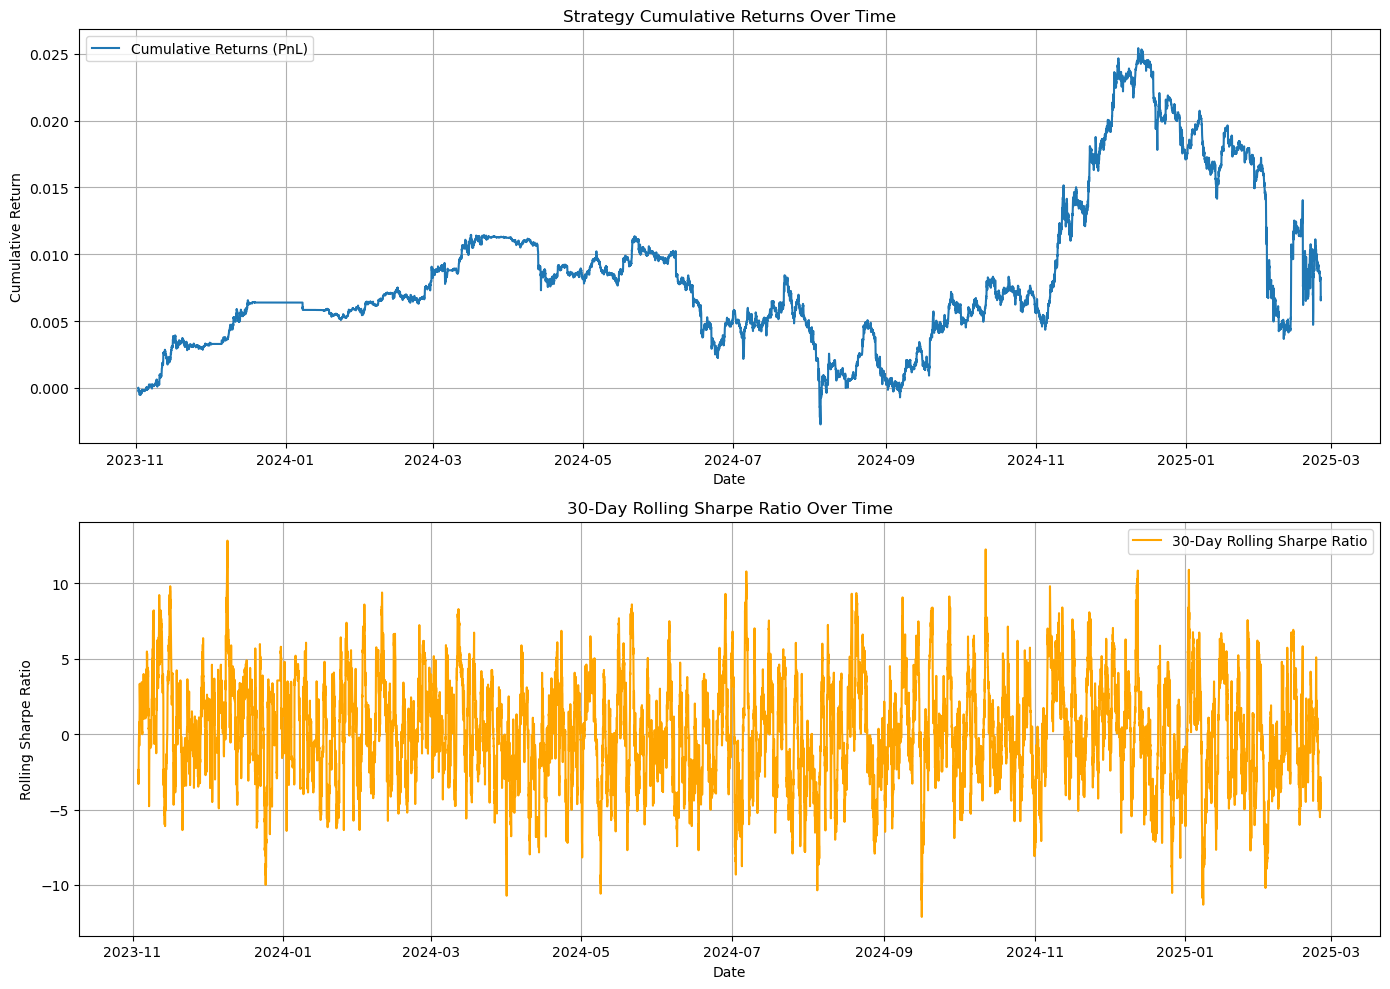

In [32]:
dates = test_data.index

cumulative_returns_series = pd.Series(cumulative_returns_test, index=dates)

returns_series = pd.Series(strategy_returns_test, index=dates)

window = 30

rolling_sharpe = returns_series.rolling(window=window).apply(
    lambda r: (np.mean(r) / np.std(r) * np.sqrt(365)) if np.std(r) != 0 else 0,
    raw=True
)

plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
plt.plot(cumulative_returns_series.index, cumulative_returns_series, label='Cumulative Returns (PnL)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Strategy Cumulative Returns Over Time')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(rolling_sharpe.index, rolling_sharpe, label=f'{window}-Day Rolling Sharpe Ratio', color='orange')
plt.xlabel('Date')
plt.ylabel('Rolling Sharpe Ratio')
plt.title(f'{window}-Day Rolling Sharpe Ratio Over Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Number of training samples: 26931
Training run 1/10
Training run 2/10
Training run 3/10
Training run 4/10
Training run 5/10
Training run 6/10
Training run 7/10
Training run 8/10
Training run 9/10
Training run 10/10
Test Loss (averaged model): 0.9689, Test Accuracy (averaged model): 0.8932
 44/361 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

C:\Users\matth\AppData\Local\Temp\ipykernel_13748\2769006025.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['asset_return'] = test_data['price_close'].pct_change()


361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Trading Performance on Test Data (Latter 30%):
Total PnL (percentage): -1.83%
Absolute PnL: $-1,831.44
Annualized Sharpe Ratio: -0.1824


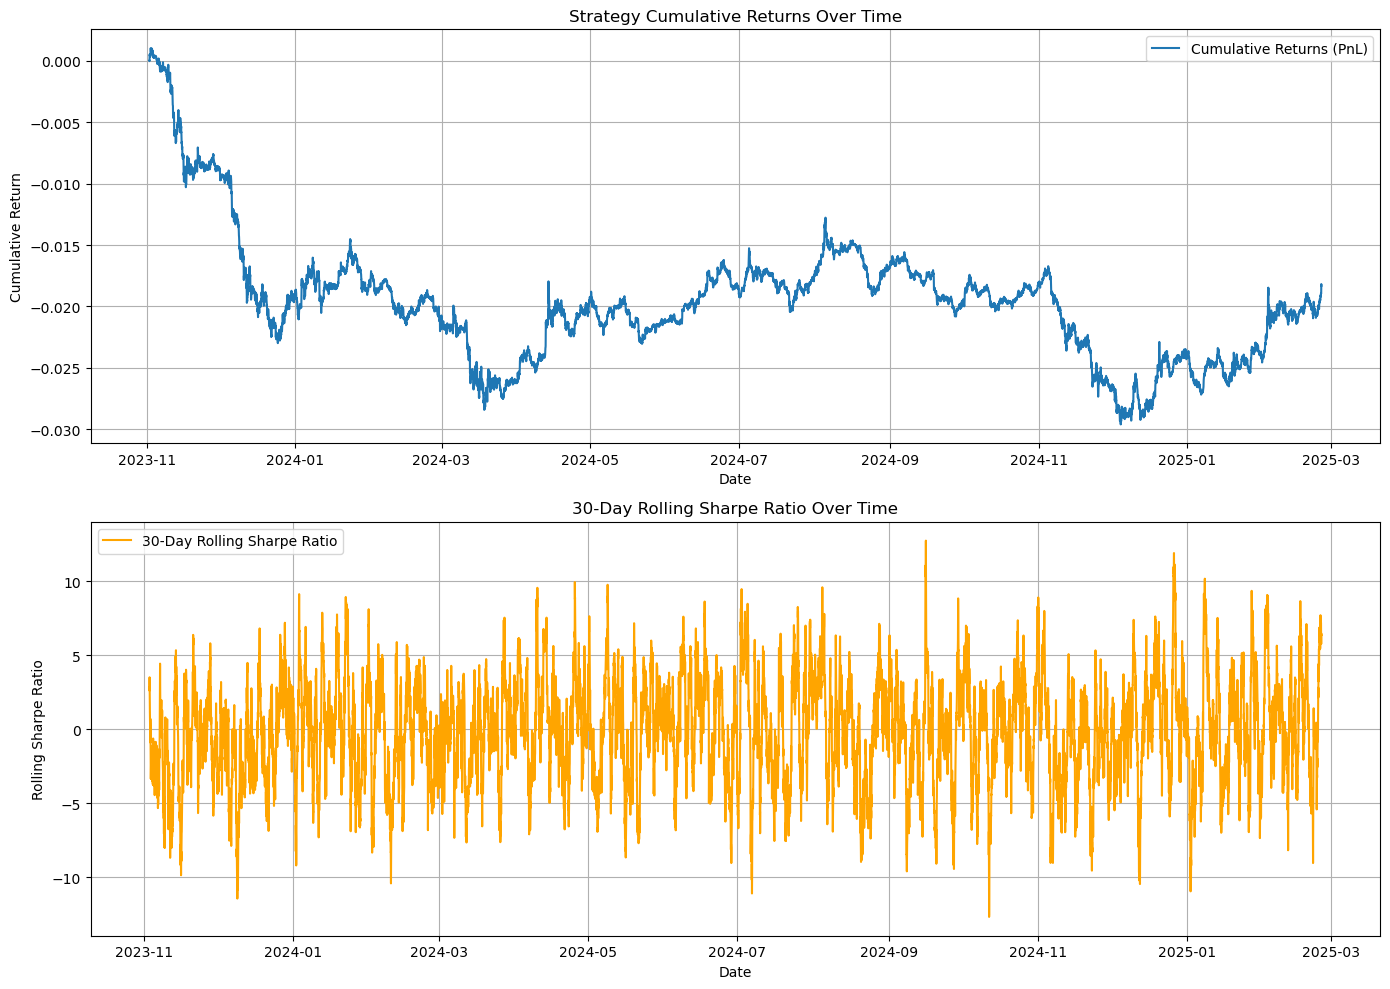

In [35]:
cutoff = int(len(data) * 0.7)
train_data = data.iloc[:cutoff]
test_data  = data.iloc[cutoff:]

features_train = train_data[lag_cols].values
labels_train = train_data['Signal'].values

print("Number of training samples:", len(labels_train))

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels_train)
y_train = to_categorical(integer_encoded)

scaler = StandardScaler()
X_train = scaler.fit_transform(features_train)

features_test = test_data[lag_cols].values
labels_test = test_data['Signal'].values
integer_encoded_test = label_encoder.transform(labels_test)
y_test = to_categorical(integer_encoded_test)
X_test = scaler.transform(features_test)


def create_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape = (X_train.shape[1],)


num_runs = 10
all_weights = []

for run in range(num_runs):
    print(f"Training run {run+1}/{num_runs}")
    model_run = create_model(input_shape)
    model_run.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
    all_weights.append(model_run.get_weights())

average_weights = []
for weights_tuple in zip(*all_weights):
    avg_weight = np.mean(np.array(weights_tuple), axis=0)
    average_weights.append(avg_weight)



avg_model = create_model(input_shape)
avg_model.set_weights(average_weights)

loss, accuracy = avg_model.evaluate(X_test, y_test, verbose=0)
print("Test Loss (averaged model): {:.4f}, Test Accuracy (averaged model): {:.4f}".format(loss, accuracy))


test_data['asset_return'] = test_data['price_close'].pct_change()
strategy_data = test_data.dropna().copy()

features_test_aligned = strategy_data[lag_cols].values
X_test_aligned = scaler.transform(features_test_aligned)

y_pred_test_aligned = avg_model.predict(X_test_aligned)
positions_test_aligned = y_pred_test_aligned[:, 0] - y_pred_test_aligned[:, 2]

asset_returns_test = strategy_data['asset_return'].values.astype(np.float32)

strategy_returns_test = np.roll(positions_test_aligned, shift=1) * asset_returns_test
strategy_returns_test[0] = 0

cumulative_returns_test = np.cumprod(1 + strategy_returns_test) - 1
total_pnl_percentage = cumulative_returns_test[-1]
sharpe_ratio_test = (np.mean(strategy_returns_test) / np.std(strategy_returns_test)) * np.sqrt(365)
initial_capital = 100000
absolute_pnl_test = total_pnl_percentage * initial_capital

print("\nTrading Performance on Test Data (Latter 30%):")
print("Total PnL (percentage): {:.2%}".format(total_pnl_percentage))
print("Absolute PnL: ${:,.2f}".format(absolute_pnl_test))
print("Annualized Sharpe Ratio: {:.4f}".format(sharpe_ratio_test))


dates = strategy_data.index
cumulative_returns_series = pd.Series(cumulative_returns_test, index=dates)
returns_series = pd.Series(strategy_returns_test, index=dates)

window = 30
rolling_sharpe = returns_series.rolling(window=window).apply(
    lambda r: (np.mean(r) / np.std(r) * np.sqrt(365)) if np.std(r) != 0 else 0,
    raw=True
)

plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
plt.plot(cumulative_returns_series.index, cumulative_returns_series, label='Cumulative Returns (PnL)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Strategy Cumulative Returns Over Time')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(rolling_sharpe.index, rolling_sharpe, label=f'{window}-Day Rolling Sharpe Ratio', color='orange')
plt.xlabel('Date')
plt.ylabel('Rolling Sharpe Ratio')
plt.title(f'{window}-Day Rolling Sharpe Ratio Over Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()